# DSCI 571: Supervised Machine Learning I 

## Lecture 5: More on categorical features and encoding text data

UBC Master of Data Science program, 2020-21

Instructor: Varada Kolhatkar


In [2]:
# Import libraries
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML

pd.set_option("display.max_colwidth", 200)

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    normalize,
    scale,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

### Learning objectives 

From this lecture, you will be able to 

1. explain `handle_unknown="ignore"` hyperparameter of `scikit-learn`'s `OneHotEncoder`;
2. identify when it's appropriate to apply ordinal encoding vs one-hot encoding;
3. explain strategies to deal with categorical variables with too many categories; 
4. explain why text data needs a different treatment than categorical variables;
5. use `scikit-learn`'s `CountVectorizer` to encode text data;
5. explain different hyperparameters of `CountVectorizer`.

###  `ColumnTransformer` <a name="7"></a>
- sklearn's [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) makes this more manageable.
    - A big advantage here is that we build all our transformations together into one object, and that way we're sure we do the same operations to all splits of the data. 
    - Otherwise we might, for example, do the OHE on both train and test but forget to scale the test data.    

<img src='./img/column-transformer.png' width="1500">

[Adapted from here.](https://amueller.github.io/COMS4995-s20/slides/aml-04-preprocessing/#37)

In [53]:
from sklearn.compose import ColumnTransformer

In [54]:
X_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_household,population_per_household
6051,-117.75,34.04,22.0,2948.0,636.0,2600.0,602.0,3.1250,INLAND,4.897010,1.056478,4.318937
20113,-119.57,37.94,17.0,346.0,130.0,51.0,20.0,3.4861,INLAND,17.300000,6.500000,2.550000
14289,-117.13,32.74,46.0,3355.0,768.0,1457.0,708.0,2.6604,NEAR OCEAN,4.738701,1.084746,2.057910
13665,-117.31,34.02,18.0,1634.0,274.0,899.0,285.0,5.2139,INLAND,5.733333,0.961404,3.154386
14471,-117.23,32.88,18.0,5566.0,1465.0,6303.0,1458.0,1.8580,NEAR OCEAN,3.817558,1.004801,4.323045


In [55]:
X_train.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'rooms_per_household', 'bedrooms_per_household',
       'population_per_household'],
      dtype='object')

In [56]:
# Identify the categorical and numeric columns
numeric_features = [
    "longitude",
    "latitude",
    "housing_median_age",
    "total_rooms",
    "total_bedrooms",
    "population",
    "households",
    "median_income",
    "rooms_per_household",
    "bedrooms_per_household",
    "population_per_household",
]

categorical_features = ["ocean_proximity"]
# reamainder_features = ["median_income"]

- Let's build a pipeline for our dataset
- create the preprocessing pipelines for both numeric and categorical data.


In [57]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)


categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    # remainder='passthrough'
)

- The `ColumnTransformer` syntax is somewhat similar to Pipeline in that you pass in a list of tuples.
- But here each tuple has 3 values instead of 2: (name, object, list of columns)

- A big advantage here is that we build all our transformations together into one object, and that way we're sure we do the same operations to all splits of the data.

- Otherwise we might, for example, do the OHE on both train and test but forget to scale the test data.


In [58]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income',
                                  'rooms_per_household',
                                  'bedrooms_per_household',
                                  'population_per_household']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('

When we `fit` with the preprocessor, it calls `fit` on _all_ the transformers

In [59]:
X_train_pp = preprocessor.transform(X_train)

When we transform with the preprocessor, it calls `transform` on _all_ the transformers.

We can get the new names of the columns that were generated by the one-hot encoding:

In [60]:
preprocessor.named_transformers_["cat"].named_steps["onehot"].get_feature_names(
    categorical_features
)

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

Combining this with the numeric feature names gives us all the column names:

In [62]:
columns = numeric_features + list(
    preprocessor.named_transformers_["cat"]
    .named_steps["onehot"]
    .get_feature_names(categorical_features)
)
columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'rooms_per_household',
 'bedrooms_per_household',
 'population_per_household',
 'ocean_proximity_<1H OCEAN',
 'ocean_proximity_INLAND',
 'ocean_proximity_ISLAND',
 'ocean_proximity_NEAR BAY',
 'ocean_proximity_NEAR OCEAN']

In [67]:
results_dict = {}
from sklearn.svm import SVR

pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        # ("reg", KNeighborsRegressor()),
        ("reg", SVR(gamma=0.01)),
    ]
)

In [68]:
scores = cross_validate(pipe, X_train, y_train, return_train_score=True)
store_cross_val_results("imp + scaling + ohe + SVR", scores, results_dict)
pd.DataFrame(results_dict).T

,mean_fit_time (s),mean_score_time (s),mean_train_score,mean_validation_score,std_train_score,std_validation_score
imp + scaling + ohe + SVR,6.5684,0.9774,-0.0526,-0.0531,0.0009,0.0108


- Note that categorical features are different than free text features. Sometimes there are columns containing free text information and we we'll look at ways to deal with them later in the course. 

### `remainder="passthrough"`
- Side note: the `ColumnTransformer` will automatically remove columns that are not being transformed:
- Use `remainder="passthrough"` of `ColumnTransformer` to keep the other columns in tact. 

#### Preprocessing the targets?

- Generally no need for this when doing classification. 
- In regression it makes sense in some cases. More on this in 573. 
- `sklearn` is fine with categorical labels ($y$-values) for classification problems. 

## 1. More on categorical features

## Data 

We'll be using [the adult census dataset](https://www.kaggle.com/uciml/adult-census-income#) you used in lab 2. 

This is a classification dataset and the classification task is to predict whether income exceeds 50K per year or not based on the census data. You can find more information on the dataset and features [here](http://archive.ics.uci.edu/ml/datasets/Adult).

The code below loads the data CSV (assuming that it is saved as `data/adult.csv` in this folder). 

*Note that many popular datasets have sex as a feature where the possible values are male and female. This representation reflects how the data were collected and is not meant to imply that, for example, gender is binary.*

In [3]:
adult_df_large = pd.read_csv("data/adult.csv")

In [4]:
train_df, test_df = train_test_split(adult_df_large, test_size=0.2, random_state=42)

In [5]:
train_df_nan = train_df.replace("?", np.NaN)
test_df_nan = test_df.replace("?", np.NaN)

In [6]:
train_df_nan.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
5514,26,Private,256263,HS-grad,9,Never-married,Craft-repair,Not-in-family,White,Male,0,0,25,United-States,<=50K
19777,24,Private,170277,HS-grad,9,Never-married,Other-service,Not-in-family,White,Female,0,0,35,United-States,<=50K
10781,36,Private,75826,Bachelors,13,Divorced,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32240,22,State-gov,24395,Some-college,10,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,20,United-States,<=50K
9876,31,Local-gov,356689,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,<=50K


In [7]:
train_df_nan["income"].value_counts(normalize=True)

<=50K    19744
>50K      6304
Name: income, dtype: int64

In the lab we took the simplest approach and and divided the feature in these two categories. 

In [7]:
numeric_features = [
    "age",
    "fnlwgt",
    "education.num",
    "capital.gain",
    "capital.loss",
    "hours.per.week",
]

categorical_features = [
    "workclass",
    "education",
    "marital.status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native.country",
]

target = "income"

In [8]:
X_train = train_df_nan.drop(columns=[target])
y_train = train_df_nan[target]

X_test = test_df_nan.drop(columns=[target])
y_test = test_df_nan[target]

- We defined transformations on numeric and categorical features,  
- a column transformer, 
- a pipeline.

In [9]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("clf", SVC()),
    ]
)

### `make_pipeline` syntax

Let's create a column transformer and a pipeline using an alternative syntax `make_pipeline`. 

- shorthand for the `Pipeline` constructor
- does not permit, naming the steps
- instead, their names will be set to the lowercase of their types automatically

In [10]:
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(),
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)
pipe = make_pipeline(preprocessor, SVC())

### `handle_unknown="ignore"`

In [11]:
scores = cross_validate(pipe, X_train, y_train, cv=5, return_train_score=True)

ValueError: Found unknown categories ['Holand-Netherlands'] in column 7 during transform

- What's going on here??
- Let's look at the error message:
`Found unknown categories ['Holand-Netherlands'] in column 6 during transform`

In [12]:
X_train["native.country"].value_counts()

United-States                 23315
Mexico                          512
Philippines                     165
Germany                         115
Canada                           97
El-Salvador                      92
Puerto-Rico                      85
India                            82
England                          74
Cuba                             70
China                            63
South                            63
Jamaica                          62
Italy                            60
Dominican-Republic               56
Columbia                         53
Vietnam                          53
Guatemala                        52
Japan                            44
Poland                           44
Taiwan                           41
Haiti                            36
Iran                             34
Portugal                         31
Nicaragua                        29
Greece                           28
Peru                             27
France                      

- There is only one instance of Holand-Netherlands.
- During cross-validation, this is getting put into the validation split.
- By default, `OneHotEncoder` throws an error because you might want to know about this.

Simplest fix:
- Pass `handle_unknown="ignore"` argument to `OneHotEncoder`
- It creates a row with all zeros. 

In [13]:
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore"),
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)
pipe = make_pipeline(preprocessor, SVC())

In [14]:
scores = cross_validate(pipe, X_train, y_train, cv=5, return_train_score=True)
pd.DataFrame(scores).mean()

fit_time       8.028445
score_time     1.249983
test_score     0.855421
train_score    0.867792
dtype: float64

- Do you want this behaviour? 
- Are you expecting to get many unknown categories? Do you want to be able to distinguish between them?
- With this approach, all unknown categories will be represented with all zeros. 

### Cases where it's OK to break the golden rule 

- If it's some fix number of categories. For example, if it's something like courses in MDS. We know the categories in advance and this is one of the cases where it might be OK to violate the golden rule and get a list of all possible values for the categorical variable. 

A common question that came up in the lab: 
- What types of features are present in this dataset other than numeric and categorical features? 

### Ordinal encoding

In [15]:
train_df[categorical_features].head()

,workclass,education,marital.status,occupation,relationship,race,sex,native.country
5514,Private,HS-grad,Never-married,Craft-repair,Not-in-family,White,Male,United-States
19777,Private,HS-grad,Never-married,Other-service,Not-in-family,White,Female,United-States
10781,Private,Bachelors,Divorced,Adm-clerical,Unmarried,White,Female,United-States
32240,State-gov,Some-college,Married-civ-spouse,Adm-clerical,Wife,White,Female,United-States
9876,Local-gov,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States


- Most of the columns are actually categorical columns, in the sense that there is no ordinality among values. 
- What about _education_ column? 

- There is actually an order in the values and it might help to encode this column using `OrdinalEncoder`
    - Example: Masters > 10th    

In [16]:
train_df["education"].unique()

array(['HS-grad', 'Bachelors', 'Some-college', '11th', '5th-6th',
       'Assoc-voc', 'Masters', '9th', 'Doctorate', 'Prof-school',
       '7th-8th', '10th', '12th', '1st-4th', 'Assoc-acdm', 'Preschool'],
      dtype=object)

In [17]:
oe = OrdinalEncoder(dtype=int)
oe.fit(X_train[["education"]])
ed_transformed = oe.transform(X_train[["education"]])
ed_transformed = pd.DataFrame(
    data=ed_transformed, columns=["education_enc"], index=X_train.index
)
ed_transformed.head()
oe.categories_[-1]

array(['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th',
       'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad',
       'Masters', 'Preschool', 'Prof-school', 'Some-college'],
      dtype=object)

In [18]:
pd.DataFrame(
    data=np.arange(len(oe.categories_[0])),
    columns=["transformed"],
    index=oe.categories_[0],
).head(10)

,transformed
10th,0
11th,1
12th,2
1st-4th,3
5th-6th,4
7th-8th,5
9th,6
Assoc-acdm,7
Assoc-voc,8
Bachelors,9


- `OrdinalEncoder` has encoded the categories by alphabetically sorting them and then assigning integers to them in that order.
- Is this what we want? 

In [19]:
train_df["education"].unique()

array(['HS-grad', 'Bachelors', 'Some-college', '11th', '5th-6th',
       'Assoc-voc', 'Masters', '9th', 'Doctorate', 'Prof-school',
       '7th-8th', '10th', '12th', '1st-4th', 'Assoc-acdm', 'Preschool'],
      dtype=object)

Let's order them manually. 

In [20]:
education_levels = [
    "Preschool",
    "1st-4th",
    "5th-6th",
    "7th-8th",
    "9th",
    "10th",
    "11th",
    "12th",
    "HS-grad",
    "Prof-school",
    "Assoc-voc",
    "Assoc-acdm",
    "Some-college",
    "Bachelors",
    "Masters",
    "Doctorate",
]

In [21]:
assert set(education_levels) == set(train_df["education"].unique())

In [22]:
oe = OrdinalEncoder(categories=[education_levels], dtype=int)
oe.fit(X_train[["education"]])
ed_transformed = oe.transform(X_train[["education"]])
ed_transformed = pd.DataFrame(
    data=ed_transformed, columns=["education_enc"], index=X_train.index
)
oe.categories_

[array(['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th',
        '11th', '12th', 'HS-grad', 'Prof-school', 'Assoc-voc',
        'Assoc-acdm', 'Some-college', 'Bachelors', 'Masters', 'Doctorate'],
       dtype=object)]

In [23]:
numeric_features = ["age", "fnlwgt", "capital.gain", "capital.loss", "hours.per.week"]
categorical_features = [
    "workclass",
    "marital.status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native.country",
]
ordinal_features = ["education"]
target_column = "income"

In [24]:
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore"),
)

ordinal_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OrdinalEncoder(
        categories=[education_levels],
        dtype=int,
    ),
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("ordinal", ordinal_transformer, ordinal_features),
    ]
)
pipe = make_pipeline(preprocessor, SVC())

In [25]:
scores = cross_validate(pipe, X_train, y_train, return_train_score=True)

In [26]:
pd.DataFrame(scores).mean()

fit_time       6.670280
score_time     1.131099
test_score     0.851927
train_score    0.853348
dtype: float64

### Binary features 

- In this dataset the only feature coded with two possible values in the dataset is sex.
- Let's try OHE on that feature. 

In [27]:
numeric_features = ["age", "fnlwgt", "capital.gain", "capital.loss", "hours.per.week"]
categorical_features = [
    "workclass",
    "marital.status",
    "occupation",
    "relationship",
    "race",
    "native.country",
]
ordinal_features = ["education"]
binary_features = ["sex"]
target_column = "income"

In [28]:
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore"),
)

ordinal_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OrdinalEncoder(
        categories=[education_levels],
        dtype=int,
    ),
)

binary_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(drop="if_binary", dtype=int),
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("ordinal", ordinal_transformer, ordinal_features),
        ("binary", binary_transformer, binary_features),
    ]
)
pipe = make_pipeline(preprocessor, SVC())

In [29]:
scores = cross_validate(pipe, X_train, y_train, return_train_score=True)

In [30]:
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,6.654067,1.100806,0.850864,0.853153
1,6.412274,1.083333,0.844530,0.855792
2,6.531355,1.108229,0.859693,0.850609
3,6.482359,1.103760,0.849299,0.853832
4,6.491378,1.106489,0.854291,0.853448


### OHE with many categories

In [31]:
X_train["native.country"].value_counts()

United-States                 23315
Mexico                          512
Philippines                     165
Germany                         115
Canada                           97
El-Salvador                      92
Puerto-Rico                      85
India                            82
England                          74
Cuba                             70
China                            63
South                            63
Jamaica                          62
Italy                            60
Dominican-Republic               56
Columbia                         53
Vietnam                          53
Guatemala                        52
Japan                            44
Poland                           44
Taiwan                           41
Haiti                            36
Iran                             34
Portugal                         31
Nicaragua                        29
Greece                           28
Peru                             27
France                      

- Do we have enough data for rare categories to learn anything meaningful? 
- How about grouping them into bigger categories
    - Example: "South America" or "Asia"
- Or having "other" category for rare cases? 

### Do we actually want to use certain features for prediction?

- Do you want to use `race` in prediction?
- Remember that the systems you build are going to be used in some applications. 
- It's extremely important to be mindful of the consequences of including certain features in your predictive model. 
- I would just drop the feature to avoid racial biases. 

### Categorical features (True or False)

- `handle_unknown="ignore"` would treat all unknown categories equally. 
- Creating groups of rarely occurring categories might overfit the model. 

## 2. Encoding text data  

- ML algorithms we have seen so far prefer numeric and fixed length input that looks like this: 

$$X = \begin{bmatrix}1.0 & 4.0 & \ldots & & 3.0\\ 0.0 & 2.0 & \ldots & & 6.0\\ 1.0 & 0.0 & \ldots & & 0.0\\ \end{bmatrix}$$ 

and 
$$y = \begin{bmatrix}spam \\ non spam \\ spam \end{bmatrix}$$

- But what if we are only given data in the form of raw text and associated labels?
- How can we represent such data into fixed number of features? 

### Spam/non-spam toy example

Would you be able to apply the algorithms we have seen so far on the data that looks like this?

$X = \begin{bmatrix}\text{"URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!",}\\ \text{"Lol your always so convincing."}\\ \text{"Congrats! 1 year special cinema pass for 2 is yours. call 09061209465 now!"}\\ \end{bmatrix}$ 

and 

$y = \begin{bmatrix}spam \\ non spam \\ spam \end{bmatrix}$

- In categorical features or ordinal features, we have fixed number of categories.
- In text features such as above, each feature value (i.e., each text message) is going to be different. 
- How do we encode these feature? 

### Bag of words (BOW) representation

- One way is to use a simple bag of words (BOW) representation which involves two components. 
    - The vocabulary (all unique words in all documents) 
    - A value indicating either the presence or absence or the count of each word in the document. 
        
<center>
<img src='./img/bag-of-words.png' width="800">
</center>

[Source](https://web.stanford.edu/~jurafsky/slp3/4.pdf)       

### Extracting BOW features using `scikit-learn`
- `CountVectorizer`
    - Converts a collection of text documents to a matrix of word counts.  
    - Each row represents a "document" (e.g., a text message in our example). 
    - Each column represents a word in the vocabulary in the training data. 
    - Each cell represents how often the word occurs in the document. 
    
    
Note: In the NLP community a text data set is referred to as a **corpus** (plural: corpora).    

In [32]:
X = [
    "URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!",
    "Lol you are always so convincing.",
    "Nah I don't think he goes to usf, he lives around here though",
    "URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!",
    "Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030",
    "As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune",
]
y = ["spam", "non spam", "non spam", "spam", "spam", "non spam"]
vec = CountVectorizer()
X_counts = vec.fit_transform(X)
bow_df = pd.DataFrame(X_counts.toarray(), columns=sorted(vec.vocabulary_), index=X)
bow_df

,08002986030,100000,11,900,all,always,are,around,as,been,...,update,urgent,usf,valued,vettam,week,with,won,you,your
URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!,0,0,0,1,0,0,0,0,1,1,...,0,1,0,1,0,0,0,0,1,0
Lol you are always so convincing.,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
"Nah I don't think he goes to usf, he lives around here though",0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,1,0
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,1,0,1,0,0,0,0,0,0,0,...,2,0,0,0,0,0,1,0,0,1
As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,0,0,0,0,1,0,0,0,2,1,...,0,0,0,0,1,0,0,0,0,3


In [33]:
X_counts

<6x72 sparse matrix of type '<class 'numpy.int64'>'
	with 85 stored elements in Compressed Sparse Row format>

In [34]:
print("The total number of elements: ", np.prod(X_counts.shape))
print("The number of non-zero elements: ", X_counts.nnz)
print(
    "Proportion of non-zero elements: %0.4f" % (X_counts.nnz / np.prod(X_counts.shape))
)
print(
    "The value at cell 3,%d is: %d"
    % (vec.vocabulary_["jackpot"], X_counts[3, vec.vocabulary_["jackpot"]])
)

The total number of elements:  432
The number of non-zero elements:  85
Proportion of non-zero elements: 0.1968
The value at cell 3,31 is: 1


### Why sparse matrices? 

- Most words do not appear in a given document.
- We get massive computational savings if we only store the nonzero elements.
- There is a bit of overhead, because we also need to store the locations:
    - e.g. "location (3,31): 1".
    
- However, if the fraction of nonzero is small, this is a huge win.


Question for you
- What would happen if you apply `StandardScaler` on sparse data? 

### `OneHotEncoder` and sparse features 
- By default, `OneHotEncoder` also creates sparse features. 
- You could set `sparse=False` to get a regular `numpy` array. 
- If there are a huge number of categories, it may be beneficial to keep them sparse.
- For smaller number of categories, it doesn't matter much.

### Important hyperparameters of `CountVectorizer` 

- `binary`
    - whether to use absence/presence feature values or counts
- `max_features`
    - only consider top `max_features` ordered by frequency in the corpus
- `max_df`
    - ignore features which occur in more than `max_df` documents 
- `min_df` 
    - ignore features which occur in less than `min_df` documents 
- `ngram_range`
    - consider word sequences in the given range 

In [35]:
# Let's look at all features, i.e., words (along with their frequencies).
vec_all = CountVectorizer()
X_counts = vec_all.fit_transform(X)
pd.DataFrame(
    data=X_counts.sum(axis=0).tolist()[0],
    index=vec_all.get_feature_names(),
    columns=["counts"],
).sort_values("counts", ascending=False).head(20)

,counts
to,5
your,4
you,3
free,3
as,3
urgent,2
have,2
for,2
he,2
the,2


In [36]:
# We can control the size of X (the number of features) using `max_features`
vec8 = CountVectorizer(max_features=8)
X_counts = vec8.fit_transform(X)
pd.DataFrame(
    data=X_counts.sum(axis=0).tolist()[0],
    index=vec8.get_feature_names(),
    columns=["counts"],
).sort_values("counts", ascending=False)

,counts
to,5
your,4
as,3
free,3
you,3
the,2
update,2
urgent,2


In [37]:
bow_df = pd.DataFrame(X_counts.toarray(), columns=sorted(vec8.vocabulary_), index=X)
bow_df

,as,free,the,to,update,urgent,you,your
URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!,1,0,0,1,0,1,1,0
Lol you are always so convincing.,0,0,0,0,0,0,1,0
"Nah I don't think he goes to usf, he lives around here though",0,0,0,1,0,0,0,0
URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!,0,1,0,0,0,1,1,0
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,0,2,2,2,2,0,0,1
As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,2,0,0,1,0,0,0,3


In [38]:
vec8_binary = CountVectorizer(binary=True, max_features=8)
X_counts = vec8_binary.fit_transform(X)
pd.DataFrame(
    data=X_counts.sum(axis=0).tolist()[0],
    index=vec8.get_feature_names(),
    columns=["counts"],
).sort_values("counts", ascending=False)

,counts
urgent,4
you,3
as,2
free,2
the,2
to,2
update,2
your,2


Notice that `vec8` and `vec8_binary` have different vocabularies, which is kind of unexpected behaviour and doesn't match the documentation of `scikit-learn`. 

[Here](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/feature_extraction/text.py#L1206-L1225) is the code for `binary=True` condition in `scikit-learn`. As we can see, the binarization is done before limiting the features to `max_features`, and so now we are actually looking at the document counts (in how many documents it occurs) rather than term count. This is not explained anywhere in the documentation. 

The ties in counts between different words makes it even more confusing. I don't think it'll have a big impact on the results but this is good to know! Remember that `scikit-learn` developers are also humans who are prone to make mistakes. So it's always a good habit to question whatever tools we use every now and then. 

In [39]:
bow_df = pd.DataFrame(
    X_counts.toarray(), columns=sorted(vec8_binary.vocabulary_), index=X
)
bow_df

,as,been,free,have,prize,to,you,your
URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!,1,1,0,1,1,1,1,0
Lol you are always so convincing.,0,0,0,0,0,0,1,0
"Nah I don't think he goes to usf, he lives around here though",0,0,0,0,0,1,0,0
URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!,0,0,1,1,1,0,1,0
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,0,0,1,0,0,1,0,1
As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,1,1,0,0,0,1,0,1


### Preprocessing

- Note that `CountVectorizer` is carrying out some preprocessing such as because of the default argument values 
    - Converting words to lowercase (`lowercase=True`)
    - getting rid of punctuation and special characters (`token_pattern ='(?u)\\b\\w\\w+\\b'`)


In [40]:
X, y

(['URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!',
  'Lol you are always so convincing.',
  "Nah I don't think he goes to usf, he lives around here though",
  'URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!',
  'Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030',
  "As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune"],
 ['spam', 'non spam', 'non spam', 'spam', 'spam', 'non spam'])

In [41]:
pipe = make_pipeline(CountVectorizer(), SVC())

In [42]:
pipe.fit(X, y)

Pipeline(steps=[('countvectorizer', CountVectorizer()), ('svc', SVC())])

In [43]:
pipe.predict(X)

array(['spam', 'non spam', 'non spam', 'spam', 'spam', 'non spam'],
      dtype='<U8')

In [44]:
pipe.score(X, y)

1.0

### Is this a realistic representation of text data? 

- Of course this is not a great representation of language
    - We are throwing out everything we know about language and losing a lot of information. 
    - It assumes that there is no syntax and compositional meaning in language.  
- But it works surprisingly well for many tasks. 
- We will learn more expressive representations later in the program in DSCI 575 (my favorite course :))! 

In the lab you'll develop a system for spam identification on a dataset from Kaggle. 

### `CountVectorizer`: True or False

- As you increase the value for `max_features` hyperparameter of `CountVectorizer` the training score is likely to go up. 
    - Varada's answer: True because increasing the value of `max_features` means we include each and every word from the training data in the dictionary and the training score is likely to go up. 
- If we encounter a word in the validation or the test split that's not available in the training data, we'll get an error. 
    - Varada's answer: False because if the word isn't in the dictionary, we would just ignore the word. 
- `max_df` hyperparameter of `CountVectorizer` can be used to get rid of most frequently occurring words from the dictionary.    
    - True because words such as _a_, _the_, _in_, _of_ occur in most of the documents, and with `max_df` hyperparameter, we can control the features to be used based on the number of documents they occur in. So if we set this to a higher proportion, we can get rid of such stop words.    

In [18]:
restaurant_df

,north_america,eat_out_freq,age,n_people,price,food_type,noise_level,good_server,comments,restaurant_name,target
0,Yes,3.0,29,20,10,Other,no music,Yes,NaN,NaN,like
1,Yes,2.0,23,10,20,Chinese,low,Yes,food tastes good,Midam,like
2,Yes,2.0,21,10,40,Other,low,Yes,good food,pear tree,like
3,No,2.0,24,15,40,Other,medium,Yes,My love for Korean food,Dami,like
4,Yes,5.0,23,20,10,Canadian/American,low,Yes,Good food,NaN,like
...,...,...,...,...,...,...,...,...,...,...,...
159,Yes,5.0,22,4,20,Canadian/American,low,Yes,NaN,do not remember,dislike
160,Yes,3.0,22,0,15,Chinese,no music,No,NaN,NaN,dislike
161,Yes,2.0,20,10,20,Chinese,no music,Yes,NaN,Tim Kee Kitchen,dislike
162,No,2.0,21,30,22,Chinese,high,No,The environment was very not clean. The food tasted awful.,NaN,dislike


In [46]:
restaurant_df.describe()

,eat_out_freq,age,n_people,price
count,164.000000,164.000000,1.640000e+02,164.000000
mean,2.463415,22.548780,6.100015e+04,6127.585366
std,1.556267,3.058338,7.808669e+05,78084.527814
min,0.000000,10.000000,-2.000000e+00,0.000000
25%,1.000000,21.000000,1.000000e+01,16.000000
50%,2.000000,22.000000,2.000000e+01,20.000000
75%,3.000000,23.000000,4.000000e+01,30.000000
max,7.000000,32.000000,1.000000e+07,1000000.000000


In [106]:
restaurant_df = pd.read_csv("data/cleaned_restaurant_data.csv")
restaurant_subset = restaurant_df[["n_people", "price", "target"]]
clean_restaurant_subset = restaurant_subset[restaurant_df['price'] < 200]
clean_restaurant_subset.head()

,n_people,price,target
0,20,10,like
1,10,20,like
2,10,40,like
3,15,40,like
4,20,10,like


In [114]:
X = clean_restaurant_subset.drop(columns=["target"])
y = clean_restaurant_subset["target"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [115]:
model = DecisionTreeClassifier(max_depth=4)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

In [116]:
model.score(X_train, y_train)

0.7209302325581395

In [117]:
model.score(X_test, y_test)

0.5454545454545454

In [87]:
import sys
sys.path.append("code/.")
import graphviz
import IPython
import mglearn
from IPython.display import HTML, display
from plotting_functions import *
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from utils import *



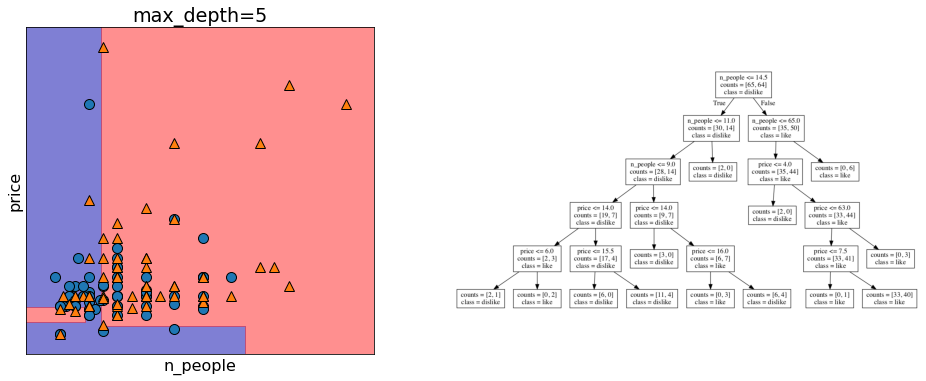

In [88]:
model = DecisionTreeClassifier(max_depth=5)
model.fit(X_train, y_train)
plot_tree_decision_boundary_and_tree(
    model,
    X_train,
    y_train,
    height=6,
    width=16,
    eps=10,
    x_label="n_people",
    y_label="price",
)